In [1]:
import os, warnings

# Silence TensorFlow / XLA / CUDA logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"   # TensorFlow log level
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score
)

from accelerate import Accelerator
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator
)

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)

E0000 00:00:1756212813.564239      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756212813.628612      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
image_dict = {}

from pathlib import Path
from tqdm import tqdm
import os

file_names = []
labels = []

for file in sorted(Path('/kaggle/input/deepfake-and-real-images/Dataset/').glob('*/*/*.*')):
    label = str(file).split('/')[-2]
    labels.append(label)
    file_names.append(str(file))

print(len(file_names), len(labels))

df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

190335 190335
(190335, 2)


In [5]:
df.head()

,image,label
0,/kaggle/input/deepfake-and-real-images/Dataset...,Fake
1,/kaggle/input/deepfake-and-real-images/Dataset...,Fake
2,/kaggle/input/deepfake-and-real-images/Dataset...,Fake
3,/kaggle/input/deepfake-and-real-images/Dataset...,Fake
4,/kaggle/input/deepfake-and-real-images/Dataset...,Fake


In [6]:
df['label'].unique()

array(['Fake', 'Real'], dtype=object)

In [7]:
print(df.columns)


Index(['image', 'label'], dtype='object')


In [8]:
import os

# Assuming df['image'] contains file paths like ".../Fake/xyz.jpg" or ".../Real/abc.png"
df["label"] = df["image"].apply(lambda x: "Fake" if "Fake" in os.path.dirname(x) else "Real")

print(df.head())
print(df["label"].value_counts())


                                               image label
0  /kaggle/input/deepfake-and-real-images/Dataset...  Fake
1  /kaggle/input/deepfake-and-real-images/Dataset...  Fake
2  /kaggle/input/deepfake-and-real-images/Dataset...  Fake
3  /kaggle/input/deepfake-and-real-images/Dataset...  Fake
4  /kaggle/input/deepfake-and-real-images/Dataset...  Fake
label
Real    95201
Fake    95134
Name: count, dtype: int64


In [9]:
import numpy as np
import pandas as pd
import gc

# Extract target as a DataFrame (to match first code)
y = df[['label']]   # double brackets -> DataFrame
df = df.drop(['label'], axis=1)

def manual_random_oversample(df, y, random_state=83):
    np.random.seed(random_state)
    
    # Ensure y is DataFrame (like imblearn does)
    if isinstance(y, pd.Series):
        y = y.to_frame()

    class_counts = y['label'].value_counts()
    majority_class = class_counts.idxmax()
    max_count = class_counts.max()

    df_resampled = df.copy()
    y_resampled = y.copy()

    for class_label in class_counts.index:
        if class_label != majority_class:
            samples_needed = max_count - class_counts[class_label]
            minority_indices = y[y['label'] == class_label].index
            sampled_indices = np.random.choice(minority_indices, size=samples_needed, replace=True)

            df_resampled = pd.concat([df_resampled, df.loc[sampled_indices]], ignore_index=True)
            y_resampled = pd.concat([y_resampled, y.loc[sampled_indices]], ignore_index=True)

    return df_resampled, y_resampled

# Perform oversampling
df, y_resampled = manual_random_oversample(df, y, random_state=83)

# Delete old y
del y

# Reattach labels
df['label'] = y_resampled

# Cleanup
del y_resampled
gc.collect()

# Final check
print(df.shape)


(190402, 2)


In [10]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())

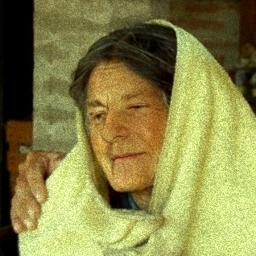

In [11]:
dataset[0]["image"]

In [12]:
labels_subset = labels[:5]

print(labels_subset) 

['Fake', 'Fake', 'Fake', 'Fake', 'Fake']


In [13]:
labels_list = ['Real', 'Fake']
label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Real', 1: 'Fake'} 

Mapping of Labels to IDs: {'Real': 0, 'Fake': 1}


In [14]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

train_data = dataset['train']

test_data = dataset['test']

Map:   0%|          | 0/190402 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/190402 [00:00<?, ? examples/s]

In [28]:
# Load the pretrained ViT image processor
model_str = "dima806/deepfake_vs_real_image_detection"
processor = ViTImageProcessor.from_pretrained(model_str)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size:", size)

normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose(
    [
        Resize((size, size)),
        RandomRotation(90),
        RandomAdjustSharpness(2),
        ToTensor(),
        normalize
    ]
)

_val_transforms = Compose(
    [
        Resize((size, size)),
        ToTensor(),
        normalize
    ]
)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size: 224


In [29]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [30]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [31]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

model.config.id2label = id2label
model.config.label2id = label2id

print(model.num_parameters(only_trainable=True) / 1e6)

85.800194


In [20]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidi

In [32]:
import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    return {
        "accuracy": acc_score
    }

In [33]:
from transformers import TrainingArguments

metric_name = "accuracy"
model_name = "deepfake_vs_real_image_detection"

num_train_epochs = 2

args = TrainingArguments(
    output_dir = model_name , 
    logging_dir='./logs',
    eval_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

In [34]:
# Create a Trainer instance for fine-tuning a language model.

# - 'model': The pre-trained language model to be fine-tuned.
# - 'args': Configuration settings and hyperparameters for training.
# - 'train_dataset': The dataset used for training the model.
# - 'eval_dataset': The dataset used for evaluating the model during training.
# - 'data_collator': A function that defines how data batches are collated and processed.
# - 'compute_metrics': A function for computing custom evaluation metrics.
# - 'tokenizer': The tokenizer used for processing text data.

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor
)

In [35]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.051400,0.023155,0.992332
2,0.047200,0.022863,0.992358


TrainOutput(global_step=3572, training_loss=0.049261969187758936, metrics={'train_runtime': 7589.6078, 'train_samples_per_second': 30.105, 'train_steps_per_second': 0.471, 'total_flos': 1.770552477112121e+19, 'train_loss': 0.049261969187758936, 'epoch': 2.0})

In [36]:
trainer.evaluate()

{'eval_loss': 0.022862577810883522,
 'eval_accuracy': 0.9923582936148423,
 'eval_runtime': 821.6883,
 'eval_samples_per_second': 92.688,
 'eval_steps_per_second': 5.794,
 'epoch': 2.0}

In [37]:
outputs = trainer.predict(test_data)

print(outputs.metrics)

{'test_loss': 0.022862577810883522, 'test_accuracy': 0.9923582936148423, 'test_runtime': 825.1174, 'test_samples_per_second': 92.303, 'test_steps_per_second': 5.77}


Accuracy: 0.9924
F1 Score: 0.9924


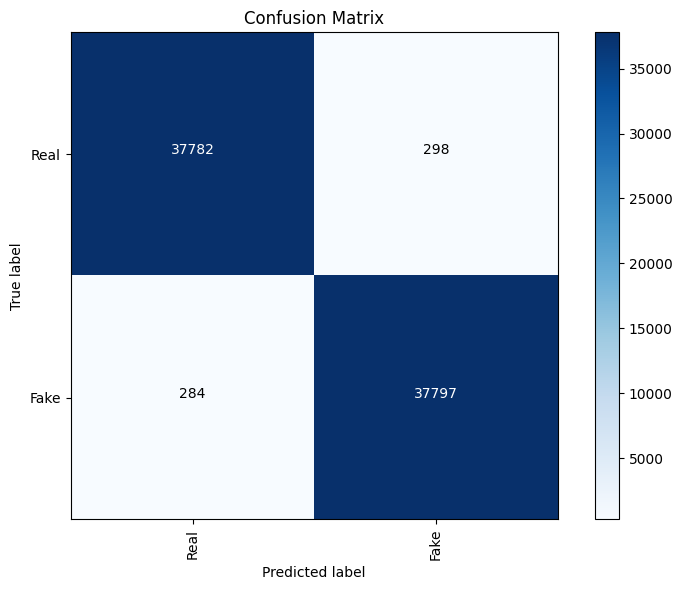


Classification report:

              precision    recall  f1-score   support

        Real     0.9925    0.9922    0.9924     38080
        Fake     0.9922    0.9925    0.9924     38081

    accuracy                         0.9924     76161
   macro avg     0.9924    0.9924    0.9924     76161
weighted avg     0.9924    0.9924    0.9924     76161



In [38]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
    cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
    classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
    title (str): Title for the plot.
    cmap (matplotlib colormap): Colormap for the plot.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [39]:
trainer.save_model()

In [40]:
from transformers import pipeline

pipe = pipeline('image-classification', model=model_name, device=0)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [43]:
import shutil

shutil.make_archive('deepfake_vs_real_image_detection', 'zip', 'deepfake_vs_real_image_detection')

'/kaggle/working/deepfake_vs_real_image_detection.zip'

In [42]:
image = test_data[1]["image"]
prediction = pipe(image)
print(prediction)

[{'label': 'Fake', 'score': 0.9992941617965698}, {'label': 'Real', 'score': 0.0007058157352730632}]


In [44]:
!ls /kaggle/working/

deepfake_vs_real_image_detection  deepfake_vs_real_image_detection.zip
